### Notebook Description

**U-Net Image Segmentation**

This notebook is designed to implement and understand the U-Net architecture, a deep learning model widely used for image segmentation tasks. The notebook walks through the process of preparing the dataset, building the U-Net model, training it, and evaluating its performance.

**Objectives:**
1. Understand the fundamentals of image segmentation and why U-Net is a popular choice for this task.
2. Learn how to preprocess and split image datasets for training and testing.
3. Implement the U-Net architecture using PyTorch.
4. Train the model and visualize its predictions to evaluate its effectiveness.

**How to Use This Notebook:**
- The notebook is divided into sections such as data preparation, model definition, training, and evaluation.
- Each section contains code and comments explaining the purpose of the steps.
- Students are encouraged to complete the TODO sections, which guide them to implement missing parts of the code or analyze results.

**What You'll Learn:**
- Practical knowledge of handling image datasets.
- Building and customizing a U-Net model.
- Evaluating deep learning models for segmentation tasks.
- Gaining hands-on experience with PyTorch.

**Prerequisites:**
- Familiarity with Python and basic programming concepts.
- A basic understanding of deep learning and PyTorch.
- Knowledge of image processing concepts (optional but helpful).

**Tips for Success:**
- Follow the comments and instructions in the code.
- Refer to the provided links and resources to understand U-Net better.
- Experiment with the code to explore how changes affect the results.

In [1]:
# This cell imports the required libraries and sets up the environment for the U-Net project.
# TODO for Students: Review these imports and identify which libraries are unfamiliar to you. Research their purpose.

# General libraries for file handling and image processing
import os
import PIL
import time
import glob
import torch
import pickle

# Libraries for data manipulation and visualization
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specific modules for image and path handling
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
!gdown "https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ" -O dataset.tar.gz
!tar -xf dataset.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ
From (redirected): https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ&confirm=t&uuid=8b8ed443-d1bb-4c06-9fe4-2420b0514f6e
To: /kaggle/working/dataset.tar.gz
100%|██████████████████████████████████████| 4.40G/4.40G [00:59<00:00, 73.9MB/s]


In [3]:
%ls

dataset/  dataset.tar.gz


In [4]:
%ls dataset

images/  masks/


In [5]:
# Specify the device to be used for computations.
# If a GPU is available, it will use GPU device 1 ("cuda:1"), otherwise it will fall back to the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_folder = Path("dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"

In [6]:
class LungDataset(torch.utils.data.Dataset):
    """
    TODO:
    1. Implement a custom PyTorch Dataset for handling lung images and segmentation masks.
    2. Initialize with the list of image-mask pairs, the origins and masks folders, and optional transformations.
    """
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        """
        TODO: Initialize the dataset with:
        - `origin_mask_list`: List of (image_name, mask_name) pairs.
        - `origins_folder`: Path to the folder containing the original images.
        - `masks_folder`: Path to the folder containing the masks.
        - `transforms`: Optional transformations to apply.
        """
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        """
        TODO:
        1. Retrieve the image and mask pair based on the provided index `idx`.
        2. Load the image and mask using `Image.open` and convert them if necessary.
        3. Apply the provided transformations if any.
        4. Normalize the image and convert the mask to a binary tensor.
        5. Return the preprocessed image and mask tensors.
        """
        origin_name, mask_name = self.origin_mask_list[idx]
        origin_path = self.origins_folder / f"{origin_name}.png"
        mask_path = self.masks_folder / f"{mask_name}.png"

        origin = Image.open(origin_path).convert("L")  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        if self.transforms is not None:
            origin, mask = self.transforms((origin, mask))

        origin = torchvision.transforms.functional.to_tensor(origin)
        mask = torchvision.transforms.functional.to_tensor(mask)
        mask = (mask > 0.5).float()  # Convert mask to binary tensor

        return origin, mask

    def __len__(self):
        """
        TODO: Return the total number of image-mask pairs in the dataset.
        """
        return len(self.origin_mask_list)


class Pad():
    """
    TODO:
    1. Create a transformation to add random padding to the image and mask.
    2. Initialize with `max_padding` to control the maximum padding size.
    """
    def __init__(self, max_padding):
        self.max_padding = max_padding

    def __call__(self, sample):
        """
        TODO:
        1. Add random padding within the range of `max_padding`.
        2. Ensure the padding is consistent for both the image and the mask.
        3. Experiment with different padding styles or fill values.
        """
        origin, mask = sample
        padding = np.random.randint(0, self.max_padding)
        origin = torchvision.transforms.functional.pad(origin, padding, fill=0)
        mask = torchvision.transforms.functional.pad(mask, padding, fill=0)
        return origin, mask


class Crop():
    """
    TODO:
    1. Implement a random cropping transformation for images and masks.
    2. Initialize with `max_shift` to control the maximum cropping shift.
    """
    def __init__(self, max_shift):
        self.max_shift = max_shift

    def __call__(self, sample):
        """
        TODO:
        1. Apply random cropping based on top-left and bottom-right shifts.
        2. Ensure the crop dimensions are consistent for both image and mask.
        3. Validate that the cropped dimensions are appropriate.
        """
        origin, mask = sample
        width, height = origin.size
        shift_x = np.random.randint(0, self.max_shift)
        shift_y = np.random.randint(0, self.max_shift)
        origin = torchvision.transforms.functional.crop(origin, shift_y, shift_x, height - shift_y, width - shift_x)
        mask = torchvision.transforms.functional.crop(mask, shift_y, shift_x, height - shift_y, width - shift_x)
        return origin, mask


class Resize():
    """
    TODO:
    1. Implement a transformation to resize the image and mask to a specific output size.
    2. Initialize with `output_size` as a tuple (height, width).
    """
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        """
        TODO:
        1. Resize both the image and the mask to the specified output size.
        2. Ensure no distortions occur during resizing unless intentional.
        """
        origin, mask = sample
        origin = torchvision.transforms.functional.resize(origin, self.output_size)
        mask = torchvision.transforms.functional.resize(mask, self.output_size)
        return origin, mask


def blend(origin, mask1=None, mask2=None):
    """
    TODO:
    1. Create a visualization function to blend the original image with one or two masks.
    2. Convert the image tensor back to a PIL image for visualization.
    3. Blend the masks with different colors and transparency levels.
    """
    # Convert origin tensor to RGB PIL Image
    img = torchvision.transforms.functional.to_pil_image(origin.squeeze()).convert("RGB")

    def create_green_mask(mask_tensor):
        """Create pure green mask (0 in R/B channels, mask value in G channel)"""
        mask_pil = torchvision.transforms.functional.to_pil_image(mask_tensor.squeeze())
        # Binarize mask (0 or 255)
        mask_pil = mask_pil.point(lambda x: 255 if x > 0.5 else 0)

        # Create RGB image with green channel only
        return Image.merge("RGB", (
            mask_pil.point(lambda x: 0),  # Red channel
            mask_pil,                     # Green channel
            mask_pil.point(lambda x: 0)   # Blue channel
        )).resize(img.size)  # Ensure matching dimensions

    def create_red_mask(mask_tensor):
        """Create pure red mask (0 in G/B channels, mask value in R channel)"""
        mask_pil = torchvision.transforms.functional.to_pil_image(mask_tensor.squeeze())
        # Binarize mask (0 or 255)
        mask_pil = mask_pil.point(lambda x: 255 if x > 0.5 else 0)

        # Create RGB image with red channel only
        return Image.merge("RGB", (
            mask_pil,  # Red channel
            mask_pil.point(lambda x: 0),  # Green channel
            mask_pil.point(lambda x: 0)   # Blue channel
        )).resize(img.size)  # Ensure matching dimensions

    # Apply green mask blending
    if mask1 is not None:
        green_mask = create_green_mask(mask1)
        img = Image.blend(img, green_mask, 0.3)

    if mask2 is not None:  # Optional second mask
        green_mask = create_red_mask(mask2)
        img = Image.blend(img, green_mask, 0.3)

    return img

In [7]:
batch_size = 4  # Batch size for training
# batch_size = 8  # for faster training!!

origins_list = [f.stem for f in origins_folder.glob("*.png")]  # List of image file names
masks_list = [f.stem for f in masks_folder.glob("*.png")]  # List of mask file names
print(len(origins_list))  # Number of images
print(len(masks_list))  # Number of masks

800
704


In [8]:
# Create a list of tuples linking masks to their corresponding images.
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

# Split data into training, validation, and testing sets.
splits = {}
splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

In [9]:
# TODO: Implement the validation and testing transformations.
val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
    # torchvision.transforms.ToTensor()
])

# TODO: Implement the training transformations by including padding, cropping, and resizing.
train_transforms = torchvision.transforms.Compose([
    Pad(max_padding=50),
    Crop(max_shift=80),
    Resize((512, 512)),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.ToTensor()
])

# TODO: Create the datasets for training, validation, and testing.
datasets = {
    "train": LungDataset(splits["train"], origins_folder, masks_folder, train_transforms),
    "val": LungDataset(splits["val"], origins_folder, masks_folder, val_test_transforms),
    "test": LungDataset(splits["test"], origins_folder, masks_folder, val_test_transforms),
}

# TODO: Initialize the dataloaders for each dataset.
dataloaders = {
    "train": torch.utils.data.DataLoader(datasets["train"], batch_size=batch_size, shuffle=True),
    "val": torch.utils.data.DataLoader(datasets["val"], batch_size=batch_size, shuffle=False),
    "test": torch.utils.data.DataLoader(datasets["test"], batch_size=batch_size, shuffle=False),
}

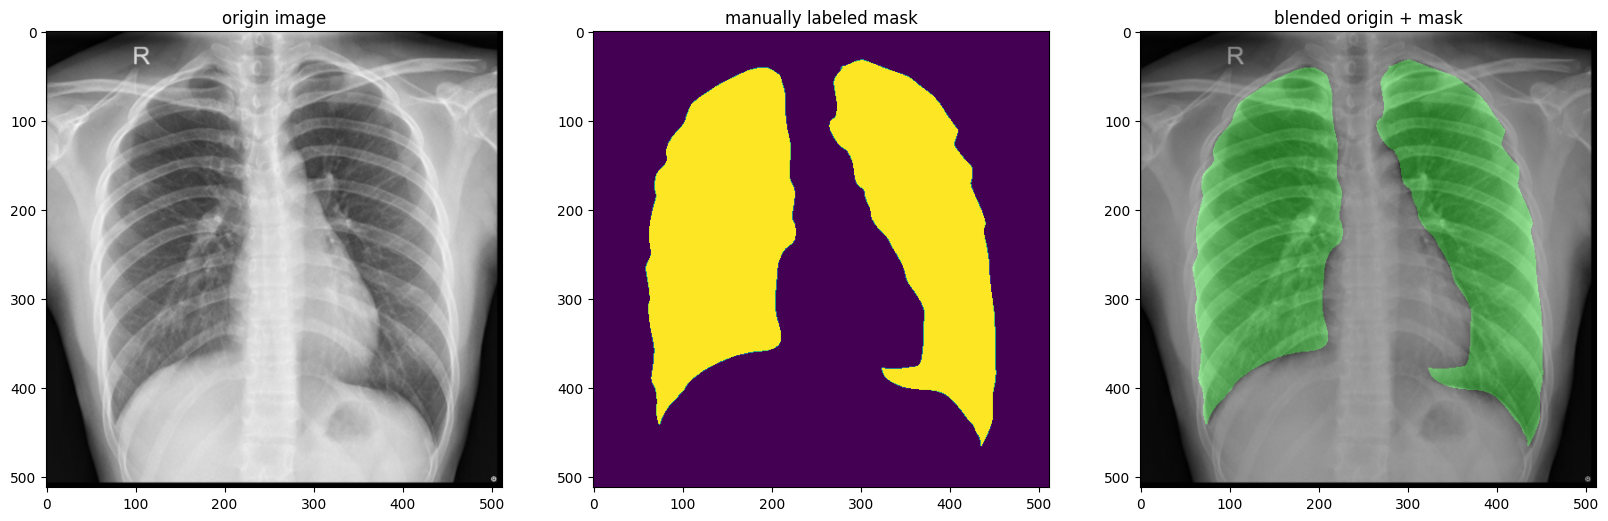

In [10]:
idx = 0
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]

# TODO: Convert the origin and mask tensors to PIL images for visualization.
pil_origin = ...
pil_mask = ...
pil_origin = torchvision.transforms.functional.to_pil_image(origin)
pil_mask = torchvision.transforms.functional.to_pil_image(mask)

# TODO: Plot the original image.
plt.subplot(1, 3, 1)
# plt.imshow(pil_origin, cmap='gray')
plt.imshow(np.array(pil_origin.convert("RGB")))
plt.title("origin image")

# TODO: Plot the manually labeled mask.
plt.subplot(1, 3, 2)
# plt.imshow(pil_mask, cmap='gray')
plt.imshow(np.array(pil_mask))
plt.title("manually labeled mask")

# TODO: Plot the blended view of the original image and mask.
plt.subplot(1, 3, 3)
blended_img = blend(origin, mask1=mask, mask2=None)
# plt.imshow(blended_img)
plt.imshow(np.array(blend(origin, mask)))
plt.title("blended origin + mask")

plt.show()

In [11]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        # TODO: Define the first convolutional layer
        # self.conv1 = None
        self.conv1 = torch.nn.Conv2d(in_channels, mid_channel, kernel_size=3, padding=1)
        # TODO: Define the second convolutional layer
        # self.conv2 = None
        self.conv2 = torch.nn.Conv2d(mid_channel, out_channels, kernel_size=3, padding=1)

        self.batch_norm = batch_norm
        if batch_norm:
            # TODO: Define batch normalization layers
            # self.bn1 = None
            # self.bn2 = None
            self.bn1 = torch.nn.BatchNorm2d(mid_channel)
            self.bn2 = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # TODO: Apply the first convolutional layer and batch normalization (if enabled)
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        return x


class UNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        # pass
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

    def down(self, x):
        # TODO: Implement max pooling for downsampling
        # pass
        return torch.nn.functional.max_pool2d(x, kernel_size=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define encoder blocks
        # self.enc1 = None
        # self.enc2 = None
        # self.enc3 = None
        # self.enc4 = None
        self.enc1 = Block(in_channels, 64, 64, batch_norm)
        self.enc2 = Block(64, 128, 128, batch_norm)
        self.enc3 = Block(128, 256, 256, batch_norm)
        self.enc4 = Block(256, 512, 512, batch_norm)

        # TODO: Define center block
        # self.center = None
        self.center = Block(512, 1024, 512, batch_norm)

        # TODO: Define decoder blocks
        # self.dec4 = None
        # self.dec3 = None
        # self.dec2 = None
        # self.dec1 = None
        self.dec4 = Block(1024, 512, 256, batch_norm)
        self.dec3 = Block(512, 256, 128, batch_norm)
        self.dec2 = Block(256, 128, 64, batch_norm)
        self.dec1 = Block(128, 64, 64, batch_norm)

        # TODO: Define final output layer
        # self.out = None
        self.out = torch.nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for UNet

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        e4 = self.enc4(self.down(e3))

        # Center
        c = self.center(self.down(e4))

        # Decoder
        d4 = self.dec4(torch.cat([self.up(c, e4.shape[-2:]), e4], dim=1)) # (B, C, W, H) --> e4.shape[-2:]=(W, H)
        d3 = self.dec3(torch.cat([self.up(d4, e3.shape[-2:]), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up(d3, e2.shape[-2:]), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2, e1.shape[-2:]), e1], dim=1))

        return self.out(d1)


class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

    def down(self, x):
        # TODO: Implement max pooling for downsampling
        return torch.nn.functional.max_pool2d(x, kernel_size=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define initial convolution layer to adjust input channels
        self.init_conv = torch.nn.Conv2d(in_channels, 3, kernel_size=1)

        # TODO: Extract pretrained VGG-11 encoder layers
        # self.conv1 = None
        # self.conv2 = None
        # self.conv3 = None
        # self.conv3s = None
        # self.conv4 = None
        # self.conv4s = None
        # self.conv5 = None
        # self.conv5s = None
        vgg11 = torchvision.models.vgg11(pretrained=True).features
        self.conv1 = vgg11[0]
        self.conv2 = vgg11[3]
        self.conv3 = vgg11[6]
        self.conv3s = vgg11[8]
        self.conv4 = vgg11[11]
        self.conv4s = vgg11[13]
        self.conv5 = vgg11[16]
        self.conv5s = vgg11[18]

        # TODO: Define center and decoder blocks
        # self.center = None
        # self.dec5 = None
        # self.dec4 = None
        # self.dec3 = None
        # self.dec2 = None
        # self.dec1 = None
        self.center = Block(512, 1024, 512, batch_norm)

        self.dec5 = Block(1024, 512, 256, batch_norm)
        self.dec4 = Block(768, 256, 128, batch_norm)
        self.dec3 = Block(384, 128, 64, batch_norm)
        self.dec2 = Block(192, 64, 32, batch_norm)
        self.dec1 = Block(96, 32, 32, batch_norm)

        # TODO: Define final output layer
        # self.out = None
        self.out = torch.nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for Pretrained UNet
        # pass
        x = self.init_conv(x)

        enc1 = torch.nn.functional.relu(self.conv1(x))
        enc2 = torch.nn.functional.relu(self.conv2(self.down(enc1)))
        enc3 = torch.nn.functional.relu(self.conv3(self.down(enc2)))
        enc3 = torch.nn.functional.relu(self.conv3s(enc3))
        enc4 = torch.nn.functional.relu(self.conv4(self.down(enc3)))
        enc4 = torch.nn.functional.relu(self.conv4s(enc4))
        enc5 = torch.nn.functional.relu(self.conv5(self.down(enc4)))
        enc5 = torch.nn.functional.relu(self.conv5s(enc5))

        center = self.center(self.down(enc5))

        dec5 = self.dec5(torch.cat([self.up(center, enc5.size()[2:]), enc5], dim=1))
        dec4 = self.dec4(torch.cat([self.up(dec5, enc4.size()[2:]), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[2:]), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[2:]), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[2:]), enc1], dim=1))

        out = self.out(dec1)
        return out

In [12]:
def jaccard(y_true, y_pred):
    """Calculate Jaccard Index (IoU) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection and union
    intersection = (y_true_flat * y_pred_flat).sum(1)
    union = ((y_true_flat + y_pred_flat) > 0.0).float().sum(1)

    # Compute Jaccard score
    score = intersection / (union + eps)
    return score.sum() / num  # Average score over batch


def dice(y_true, y_pred):
    """Calculate Dice coefficient (F1 score) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection
    intersection = (y_true_flat * y_pred_flat).sum(1)

    # Compute Dice score
    score = (2 * intersection) / (y_true_flat.sum(1) + y_pred_flat.sum(1) + eps)
    return score.sum() / num  # Average score over batch

In [13]:
# TODO: Initialize the PretrainedUNet model with appropriate parameters.
# unet = PretrainedUNet(
#     in_channels=None,  # TODO: Specify the number of input channels
#     out_channels=None,  # TODO: Specify the number of output channels
#     batch_norm=None,  # TODO: Enable or disable batch normalization
#     upscale_mode=None  # TODO: Specify the upsampling mode
# )
unet = PretrainedUNet(
    in_channels=1,  # Grayscale images
    out_channels=1,  # Binary segmentation
    batch_norm=True,
    upscale_mode="bilinear"
)

# TODO: Move the model to the appropriate device (CPU or GPU).
unet = unet.to(device)

# TODO: Print the model to verify its structure.
unet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 197MB/s]  


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): Bat

In [14]:
# TODO: Set training configurations such as log file, epochs, and optimizer.
# train_log_filename = None  # TODO: Specify log file name
# epochs = None  # TODO: Define the number of epochs
# best_val_loss = np.inf
# model_name = None  # TODO: Specify model checkpoint name
# optimizer = None  # TODO: Initialize optimizer (e.g., Adam)
train_log_filename = "training_log.txt"
epochs = 20
best_val_loss = np.inf
model_name = "best_unet_model.pth"
optimizer = torch.optim.Adam(unet.parameters(), lr=9e-5)


# TODO: Initialize history list to store training and validation metrics.
hist = []

# Training loop
for e in range(epochs):
    start_t = time.time()  # Track the start time of the epoch.

    # Training phase
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)  # Batch size

        # TODO: Move input data and targets to the device (CPU or GPU).
        # origins = None  # TODO: Move origins to device
        # masks = None  # TODO: Move masks to device
        origins = origins.to(device)
        masks = masks.to(device)

        # TODO: Reset gradients and perform forward and backward passes.
        optimizer.zero_grad()
        outputs = unet(origins)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, masks)
        loss.backward()
        optimizer.step()

        # TODO: Accumulate training loss for reporting.
        train_loss += loss.item()
        print(".", end="")  # Print progress

    train_loss = train_loss / len(datasets['train'])  # Normalize training loss
    print()

    # Validation phase
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)  # Batch size

        # TODO: Move validation data and targets to the device.
        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():  # Disable gradient computation for validation.
            # outs = None  # TODO: Perform forward pass
            # softmax = None  # TODO: Apply log-softmax (I use 1 neuron for each pixel (binary classification), so I use Sigmoid and BCE)
            # val_loss += None  # TODO: Compute validation loss
            outputs = unet(origins)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, masks)
            val_loss += loss.item()

            # TODO: Compute Jaccard and Dice metrics for evaluation.
            preds = torch.sigmoid(outputs) > 0.5
            val_jaccard += jaccard(masks, preds)
            val_dice += dice(masks, preds)

        print(".", end="")  # Print progress
    # val_loss = None  # TODO: Normalize validation loss
    # val_jaccard = None  # TODO: Normalize Jaccard score
    # val_dice = None  # TODO: Normalize Dice score
    val_loss = val_loss / len(dataloaders["val"])
    val_jaccard = val_jaccard / len(dataloaders["val"])
    val_dice = val_dice / len(dataloaders["val"])
    print()

    end_t = time.time()  # Track the end time of the epoch.
    spended_t = end_t - start_t

    # TODO: Log training and validation metrics.
    with open(train_log_filename, "a") as train_log_file:
        report = None  # TODO: Format report string
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss},\nval loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        # TODO: Append metrics to the history list for future analysis.
        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)  # TODO: Print the metrics
        train_log_file.write(report + "\n")  # TODO: Write metrics to the log file
        print()

train phase
...............................................................................................................................
validation phase
...............
epoch: 1/20, time: 152.09740948677063, train loss: 0.09902526561921764,
val loss: 0.34679115215937295, val jaccard: 0.9317516684532166, val dice: 0.9645003080368042

train phase
...............................................................................................................................
validation phase
...............
epoch: 2/20, time: 152.2587947845459, train loss: 0.08175580568699968,
val loss: 0.30521417657534283, val jaccard: 0.9138736128807068, val dice: 0.9546669721603394

train phase
...............................................................................................................................
validation phase
...............
epoch: 3/20, time: 149.73550987243652, train loss: 0.07177652695433424,
val loss: 0.2631519059340159, val jaccard: 0.9337031245231628, val dice: 0.965

epochs: 20, overall time: 50.55m, mean epoch time: 151.6508s


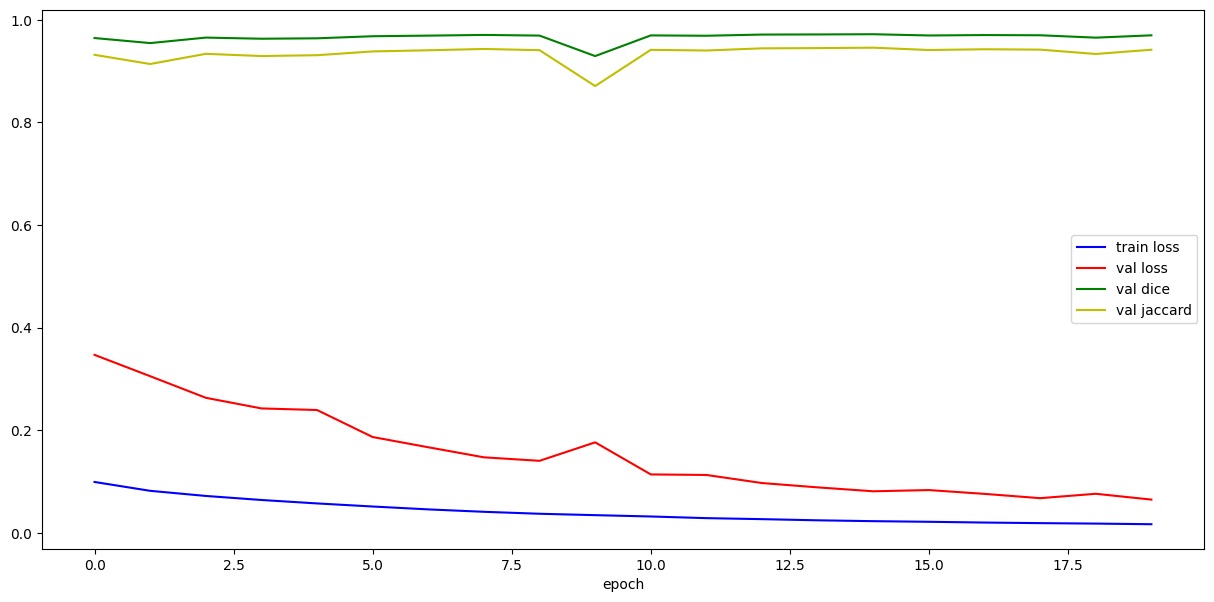

In [15]:
# TODO: Initialize a plot to visualize training and validation metrics.
plt.figure(figsize=(15, 7))

# TODO: Extract and plot training loss history.
# train_loss_hist = None  # TODO: Extract training loss from `hist`.
# plt.plot(None, None, "b", label="train loss")  # TODO: Plot training loss.
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(epochs), train_loss_hist, "b", label="train loss")

# TODO: Extract and plot validation loss history.
# val_loss_hist = None  # TODO: Extract validation loss from `hist`.
# plt.plot(None, None, "r", label="val loss")  # TODO: Plot validation loss.
val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(epochs), val_loss_hist, "r", label="val loss")

# TODO: Extract and plot Dice score history.
# val_dice_hist = None  # TODO: Extract Dice scores from `hist`.
# plt.plot(None, None, "g", label="val dice")  # TODO: Plot Dice scores.
val_dice_hist = [h["val_dice"].cpu() for h in hist]
plt.plot(range(epochs), val_dice_hist, "g", label="val dice")

# TODO: Extract and plot Jaccard score history.
# val_jaccard_hist = None  # TODO: Extract Jaccard scores from `hist`.
# plt.plot(None, None, "y", label="val jaccard")  # TODO: Plot Jaccard scores.
val_jaccard_hist = [h["val_jaccard"].cpu() for h in hist]
plt.plot(range(epochs), val_jaccard_hist, "y", label="val jaccard")

# TODO: Add labels and legend to the plot.
plt.legend()
# plt.xlabel(None)  # TODO: Add label for x-axis.
plt.xlabel("epoch")

# TODO: Compute overall training time and mean epoch time.
# time_hist = None  # TODO: Extract time per epoch from `hist`.
# overall_time = None  # TODO: Calculate total training time in minutes.
# mean_epoch_time = None  # TODO: Calculate mean epoch time.
time_hist = [entry["time"] for entry in hist]
overall_time = sum(time_hist) / 60
mean_epoch_time = np.mean(time_hist)

# TODO: Print summary of training statistics.
# print(None)  # TODO: Format and print training statistics.
print(f"epochs: {epochs}, overall time: {overall_time:.2f}m, mean epoch time: {mean_epoch_time:.4f}s")

In [23]:
# TODO: Evaluate the model on the test dataset and compute metrics.
unet.eval()
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

# TODO: Iterate through the test dataloader.
for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    # TODO: Move data to the device.
    # origins = None
    # masks = None
    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():  # Disable gradient calculation for evaluation.
        # outs = None  # TODO: Perform forward pass
        # softmax = None  # TODO: Apply log-softmax (I use 1 neuron for each pixel (binary classification), so I use Sigmoid and BCE)
        # test_loss += None  # TODO: Compute test loss
        outputs = unet(origins)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, masks)
        test_loss += loss.item()

        # TODO: Calculate Jaccard and Dice metrics.
        # outs = None  # TODO: Get class predictions
        # masks = None  # TODO: Convert masks to float
        # test_jaccard += None  # TODO: Compute Jaccard
        # test_dice += None  # TODO: Compute Dice
        preds = torch.sigmoid(outputs) > 0.5
        masks = masks.float()
        test_jaccard += jaccard(masks, preds)
        test_dice += dice(masks, preds)

    print(".", end="")  # Print progress

# TODO: Compute average metrics.
# test_loss = None  # TODO: Calculate average test loss
# test_jaccard = None  # TODO: Calculate average Jaccard score
# test_dice = None  # TODO: Calculate average Dice score
test_loss = test_loss / len(dataloaders["test"])
test_jaccard = test_jaccard / len(dataloaders["test"])
test_dice = test_dice / len(dataloaders["test"])

# TODO: Print the results.
print()
# print(None)  # TODO: Print test loss
# print(None)  # TODO: Print test Jaccard
# print(None)  # TODO: Print test Dice
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

....................................
avg test loss: 0.060150602418515414
avg test jaccard: 0.9299906492233276
avg test dice: 0.9630511403083801


red area - predict
green area - ground truth
yellow area - intersection



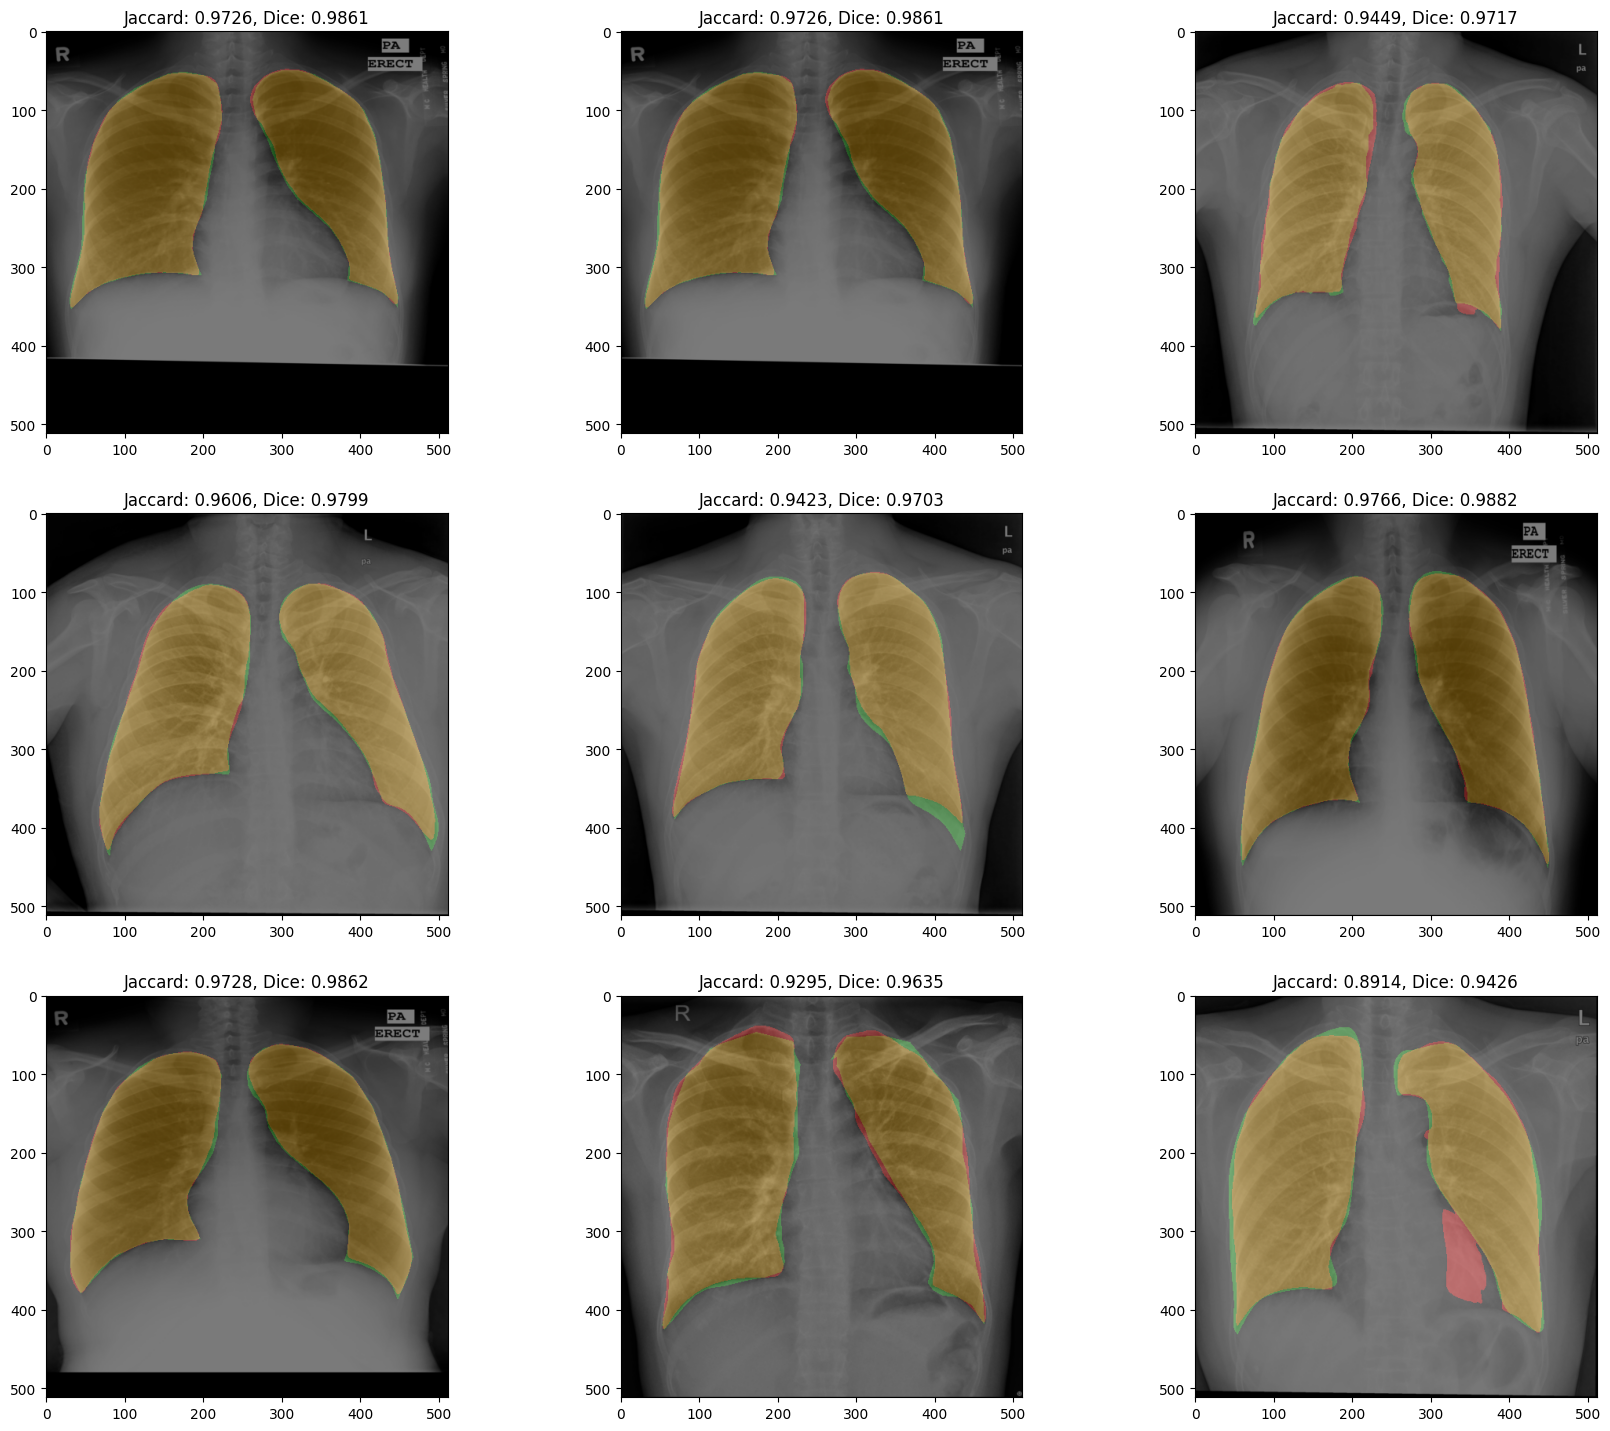

In [34]:
# TODO: Visualize predictions on random samples from the test dataset.

# Number of samples to visualize and the dataset phase.
num_samples = 9
phase = 'test'

# TODO: Create a subset of random samples from the specified phase.
subset = torch.utils.data.Subset(
    datasets[phase],
    # None  # TODO: Randomly select indices from the dataset.
    np.random.choice(len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)

# TODO: Initialize the figure for visualization.
# plt.figure(figsize=(None, None))  # TODO: Define figure size.
plt.figure(figsize=(21, 24))

# Iterate through the random samples.
for idx, (origin, mask) in enumerate(random_samples_loader):
    # plt.subplot((None // 3) + 1, 3, idx+1)  # TODO: Set subplot grid dimensions.
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    # TODO: Move the input data to the appropriate device.
    # origin = None
    # mask = None
    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():  # Disable gradient computation for prediction.
        outputs = unet(origin)
        preds = torch.sigmoid(outputs) > 0.5

        # TODO: Compute evaluation metrics (Jaccard and Dice scores).
        # jaccard_score = None
        # dice_score = None
        jaccard_score = jaccard(mask, preds)
        dice_score = dice(mask, preds)

        # TODO: Move data back to the CPU for visualization.
        # origin = None
        # out = None
        # mask = None
        origin = origin.cpu()
        out = preds.cpu()
        mask = mask.cpu()

        # TODO: Visualize the blended output (prediction and ground truth).
        out = out.float()
        masks = masks.float()
        blended_img = blend(origin[0], mask1=mask[0], mask2=out[0])
        plt.imshow(blended_img)
        plt.title(f"Jaccard: {jaccard_score:.4f}, Dice: {dice_score:.4f}")

print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")
print()